# Extraction attacks

Installing required packages

In [ ]:
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install adversarial-robustness-toolbox

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.8/30.8 MB 10.6 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2


In [ ]:
# Importing required dependencies
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from art.estimators.classification import KerasClassifier
from art.attacks.evasion import FastGradientMethod
from art.utils import load_dataset
import tensorflow.keras.backend as K

# Disabling eager execution from TF 2
tf.compat.v1.disable_eager_execution()

# Increasing Matplotlib font size
matplotlib.rcParams.update({"font.size": 15})

# Loading the data
(train_images, train_labels), (test_images, test_labels), min, max = load_dataset(name="cifar10")

In [ ]:
# Creating model
def create_model():
    # Defining the model
    model = tf.keras.models.Sequential([
        Conv2D(filters=32, kernel_size=3, activation="relu", input_shape=(32, 32, 3)),
        MaxPool2D(pool_size=2),
        Conv2D(filters=64, kernel_size=3, activation="relu"),
        MaxPool2D(pool_size=2),
        Flatten(),
        Dense(units=10, activation="softmax")
    ])

    # Compiling the model
    model.compile(
        optimizer="adam",
        loss="categorical_crossentropy",
        metrics=["accuracy"]
        )

    # Returning the model
    return model

In [ ]:
# Importing required extraction attacks
from art.attacks.extraction import CopycatCNN
from art.attacks.extraction import KnockoffNets
from art.attacks.extraction import FunctionallyEquivalentExtraction


In [ ]:
# Setting aside a subset of the source dataset for the original model
train_images_original = train_images[:4000]
train_labels_original = train_labels[:4000]

# Using the rest of the source dataset for the stolen model
train_images_stolen = train_images[4000:]
train_labels_stolen = train_labels[4000:]

In [ ]:
import tensorflow_hub as hub
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Activation, Dropout
gan_model_url = "https://tfhub.dev/deepmind/ganeval-cifar10-convnet/1"
gan_model = hub.KerasLayer(gan_model_url, trainable=False, input_shape=(32, 32, 3), dtype=tf.float32)

model_original = Sequential()
model_original.add(gan_model)
model_original.add(Flatten())
model_original.add(Dense(10))
model_original.add(Activation("softmax"))
model_original.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

# Create classifier wrapper
classifier = KerasClassifier(model_original, clip_values=(min, max))
classifier.fit(train_images_original, train_labels_original, nb_epochs=15, batch_size=128)


Train on 4000 samples
Epoch 1/15
4000/4000 [==============================] - 1s 278us/sample - loss: 5.6383 - accuracy: 0.1715
Epoch 2/15
4000/4000 [==============================] - 1s 200us/sample - loss: 4.8201 - accuracy: 0.1933
Epoch 3/15
4000/4000 [==============================] - 1s 201us/sample - loss: 4.0778 - accuracy: 0.2257
Epoch 4/15
4000/4000 [==============================] - 1s 199us/sample - loss: 3.4210 - accuracy: 0.2740
Epoch 5/15
4000/4000 [==============================] - 1s 199us/sample - loss: 2.8434 - accuracy: 0.3285
Epoch 6/15
4000/4000 [==============================] - 1s 203us/sample - loss: 2.3346 - accuracy: 0.3905
Epoch 7/15
4000/4000 [==============================] - 1s 201us/sample - loss: 1.8899 - accuracy: 0.4515
Epoch 8/15
4000/4000 [==============================] - 1s 201us/sample - loss: 1.5048 - accuracy: 0.5153
Epoch 9/15
4000/4000 [==============================] - 1s 206us/sample - loss: 1.1856 - accuracy: 0.5982
Epoch 10/15
4000/4000 [=

In [ ]:
# Wrapping the model in the ART KerasClassifier class
classifier_original = KerasClassifier(
    model=model_original,
    clip_values=(min, max))

In [ ]:
# Creating the "neural net thief" object that will steal the original classifier
copycat_cnn = CopycatCNN(
    batch_size_fit=256,
    batch_size_query=256,
    nb_epochs=15,
    nb_stolen=len(train_images_stolen),
    classifier=classifier_original
    )

In [ ]:
# Creating the "neural net thief" object that will steal the original classifier
knockoffnets = KnockoffNets(
    batch_size_fit=256,
    batch_size_query=256,
    nb_epochs=20,
    nb_stolen=len(train_images_stolen),
    classifier=classifier_original
    )

In [ ]:
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Flatten, InputLayer, Reshape
# Below is used by `FunctionallyEquivalentExtraction`.
model_flat = Sequential([InputLayer([3072]), Reshape([32, 32, 3]), model_original])
model_flat.compile('sgd', 'categorical_crossentropy', ['accuracy'])
classifier_flat_protected = KerasClassifier(model_flat, clip_values=(0, 1), use_logits=False)
functionallyequivalentextraction = FunctionallyEquivalentExtraction(classifier=classifier_flat_protected, num_neurons=128)

In [ ]:
# Creating a reference model for theft
model_stolen = KerasClassifier(
    model=create_model(),
    clip_values=(min, max)
    )

In [ ]:
# Extracting a thieved classifier by training the reference model
stolen_classifier1 = copycat_cnn.extract(
    x=train_images_stolen,
    y=train_labels_stolen,
    thieved_classifier=model_stolen
    )

/usr/local/lib/python3.9/dist-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Train on 46000 samples
Epoch 1/15
46000/46000 [==============================] - 3s 64us/sample - loss: 1.7579 - accuracy: 0.3735
Epoch 2/15
46000/46000 [==============================] - 2s 33us/sample - loss: 1.4602 - accuracy: 0.4947
Epoch 3/15
46000/46000 [==============================] - 2s 39us/sample - loss: 1.3614 - accuracy: 0.5368
Epoch 4/15
46000/46000 [==============================] - 2s 41us/sample - loss: 1.2843 - accuracy: 0.5668
Epoch 5/15
46000/46000 [==============================] - 2s 33us/sample - loss: 1.2294 - accuracy: 0.5868
Epoch 6/15
46000/46000 [==============================] - 1s 32us/sample - loss: 1.1866 - accuracy: 0.6024
Epoch 7/15
46000/46000 [==============================] - 1s 32us/sample - loss: 1.1424 - accuracy: 0.6202
Epoch 8/15
46000/46000 [==============================] - 1s 32us/sample - loss: 1.1103 - accuracy: 0.6308
Epoch 9/15
46000/46000 [==============================] - 1s 32us/sample - loss: 1.0844 - accuracy: 0.6406
Epoch 10/15
46

In [ ]:
# Extracting a thieved classifier by training the reference model
stolen_classifier2 = knockoffnets.extract(
    x=train_images_stolen,
    y=train_labels_stolen,
    thieved_classifier=model_stolen
    )

In [ ]:
#Extracts a functionally equivalent classifier using the FunctionallyEquivalentExtraction technique.
#It takes as input the flattened stolen training images and their corresponding labels, and the stolen model.
stolen_classifier3 = FunctionallyEquivalentExtraction.extract(np.reshape(train_images_stolen, [len(train_images_stolen), -1]), train_labels_stolen, thieved_classifier=model_stolen)

1.Functionallity Equivalent Extraction

2.Copycat CNN

3.Knockoff Nets


In [ ]:
# Testing the performance of the original classifier
score_original = classifier_original._model.evaluate(
    x=test_images,
    y=test_labels
    )

# Testing the performance of the stolen classifier
score_stolen = stolen_classifier1._model.evaluate(
    x=test_images,
    y=test_labels
    )

# Comparing test losses
print(f"Original test loss: {score_original[0]:.2f} "
      f"Stolen test loss: {score_stolen[0]:.2f}")

# Comparing test accuracies
print(f"Original test accuracy: {score_original[1]:.2f} "
      f"Stolen test accuracy: {score_stolen[1]:.2f}")

In [ ]:
# Testing the performance of the original classifier
score_original = classifier_original._model.evaluate(
    x=test_images,
    y=test_labels
    )

# Testing the performance of the stolen classifier
score_stolen = stolen_classifier2._model.evaluate(
    x=test_images,
    y=test_labels
    )

# Comparing test losses
print(f"Original test loss: {score_original[0]:.2f} "
      f"Stolen test loss: {score_stolen[0]:.2f}")

# Comparing test accuracies
print(f"Original test accuracy: {score_original[1]:.2f} "
      f"Stolen test accuracy: {score_stolen[1]:.2f}")

Including the accuracy of the stolen model with different percentages of the data ( 5%, 10% and 30%)

# CopyCatCNN

**Description of algorithm**

If a target black-box CNN can be copied by persuading it to confess its knowledge through random non-labeled data. The copy is two-fold: i) the target network is queried with random data and its predictions are used to create a fake dataset with the knowledge of the network; and ii) a copycat network is trained with the fake dataset and should be able to achieve similar performance as the target network.

In [ ]:
# Defining subsets to try
data_subsets_to_try = [200, 400, 1200] # 5%, 10% and 30%

# Initializing a dict to store scores
scores1 = {}

# Iterating over each data subset
for data_subset in data_subsets_to_try:
    # Creating a reference model for theft
    model_stolen = KerasClassifier(
        model=create_model(),
        clip_values=(0, 1)
        )

    # Creating the "neural net thief" object
    # to train with the current subset size
    copycat_cnn = CopycatCNN(
        batch_size_fit=256,
        batch_size_query=256,
        nb_epochs=20,
        nb_stolen=data_subset,
        classifier=classifier_original
    )

    # Extracting a thieved classifier,
    # using a subset of the stolen data
    stolen_classifier1 = copycat_cnn.extract(
        x=train_images_stolen[:data_subset],
        y=train_labels_stolen[:data_subset],
        thieved_classifier=model_stolen
        )

    # Calculating test metrics for the current stolen model
    scores1[data_subset] = stolen_classifier1._model.evaluate(
        x=test_images,
        y=test_labels
    )

Train on 200 samples
Epoch 1/20
200/200 [==============================] - 0s 2ms/sample - loss: 2.3188 - accuracy: 0.0850
Epoch 2/20
200/200 [==============================] - 0s 111us/sample - loss: 2.2817 - accuracy: 0.1250
Epoch 3/20
200/200 [==============================] - 0s 74us/sample - loss: 2.2591 - accuracy: 0.1400
Epoch 4/20
200/200 [==============================] - 0s 69us/sample - loss: 2.2438 - accuracy: 0.1450
Epoch 5/20
200/200 [==============================] - 0s 123us/sample - loss: 2.2279 - accuracy: 0.1450
Epoch 6/20
200/200 [==============================] - 0s 76us/sample - loss: 2.2072 - accuracy: 0.1650
Epoch 7/20
200/200 [==============================] - 0s 58us/sample - loss: 2.1822 - accuracy: 0.2100
Epoch 8/20
200/200 [==============================] - 0s 71us/sample - loss: 2.1542 - accuracy: 0.2500
Epoch 9/20
200/200 [==============================] - 0s 72us/sample - loss: 2.1225 - accuracy: 0.3100
Epoch 10/20
200/200 [==============================

Train on 400 samples
Epoch 1/20
400/400 [==============================] - 0s 706us/sample - loss: 2.3106 - accuracy: 0.1150
Epoch 2/20
400/400 [==============================] - 0s 54us/sample - loss: 2.2752 - accuracy: 0.1850
Epoch 3/20
400/400 [==============================] - 0s 43us/sample - loss: 2.2506 - accuracy: 0.2050
Epoch 4/20
400/400 [==============================] - 0s 45us/sample - loss: 2.2143 - accuracy: 0.2575
Epoch 5/20
400/400 [==============================] - 0s 62us/sample - loss: 2.1796 - accuracy: 0.3200
Epoch 6/20
400/400 [==============================] - 0s 46us/sample - loss: 2.1294 - accuracy: 0.3200
Epoch 7/20
400/400 [==============================] - 0s 44us/sample - loss: 2.0730 - accuracy: 0.3675
Epoch 8/20
400/400 [==============================] - 0s 44us/sample - loss: 2.0184 - accuracy: 0.3650
Epoch 9/20
400/400 [==============================] - 0s 45us/sample - loss: 1.9502 - accuracy: 0.4000
Epoch 10/20
400/400 [==============================

Train on 1200 samples
Epoch 1/20
1200/1200 [==============================] - 0s 156us/sample - loss: 2.3012 - accuracy: 0.1258
Epoch 2/20
1200/1200 [==============================] - 0s 34us/sample - loss: 2.2610 - accuracy: 0.1400
Epoch 3/20
1200/1200 [==============================] - 0s 39us/sample - loss: 2.2078 - accuracy: 0.2817
Epoch 4/20
1200/1200 [==============================] - 0s 34us/sample - loss: 2.1235 - accuracy: 0.2917
Epoch 5/20
1200/1200 [==============================] - 0s 35us/sample - loss: 2.0084 - accuracy: 0.3217
Epoch 6/20
1200/1200 [==============================] - 0s 36us/sample - loss: 1.9117 - accuracy: 0.3275
Epoch 7/20
1200/1200 [==============================] - 0s 40us/sample - loss: 1.8634 - accuracy: 0.3208
Epoch 8/20
1200/1200 [==============================] - 0s 34us/sample - loss: 1.8127 - accuracy: 0.3475
Epoch 9/20
1200/1200 [==============================] - 0s 35us/sample - loss: 1.7765 - accuracy: 0.3658
Epoch 10/20
1200/1200 [=========

The accuracy of the stolen model with different percentages of the data (5%, 10% and 30%). -
# KnockOffNets

Description of algorithm

 1.Querying a set of input images to the blackbox model to obtain predictions.

 2.Training a "knockoff" with queried image-prediction pairs.

In [ ]:
# Defining subsets to try
data_subsets_to_try = [200, 400, 1200] # 5%, 10% and 30%

# Initializing a dict to store scores
scores2 = {}

# Iterating over each data subset
for data_subset in data_subsets_to_try:
    # Creating a reference model for theft
    model_stolen = KerasClassifier(
        model=create_model(),
        clip_values=(0, 1)
        )

    # Creating the "neural net thief" object
    # to train with the current subset size
    knockoffnets = KnockoffNets(
        batch_size_fit=256,
        batch_size_query=256,
        nb_epochs=15,
        nb_stolen=data_subset,
        classifier=classifier_original
    )

    # Extracting a thieved classifier,
    # using a subset of the stolen data
    stolen_classifier2 = copycat_cnn.extract(
        x=train_images_stolen[:data_subset],
        y=train_labels_stolen[:data_subset],
        thieved_classifier=model_stolen
        )

    # Calculating test metrics for the current stolen model
    scores2[data_subset] = stolen_classifier2._model.evaluate(
        x=test_images,
        y=test_labels
    )

Train on 200 samples
Epoch 1/20
200/200 [==============================] - 0s 810us/sample - loss: 2.2909 - accuracy: 0.1350
Epoch 2/20
200/200 [==============================] - 0s 60us/sample - loss: 2.2658 - accuracy: 0.1350
Epoch 3/20
200/200 [==============================] - 0s 58us/sample - loss: 2.2478 - accuracy: 0.1550
Epoch 4/20
200/200 [==============================] - 0s 62us/sample - loss: 2.2311 - accuracy: 0.2100
Epoch 5/20
200/200 [==============================] - 0s 67us/sample - loss: 2.2112 - accuracy: 0.2250
Epoch 6/20
200/200 [==============================] - 0s 69us/sample - loss: 2.1866 - accuracy: 0.2300
Epoch 7/20
200/200 [==============================] - 0s 67us/sample - loss: 2.1575 - accuracy: 0.2700
Epoch 8/20
200/200 [==============================] - 0s 62us/sample - loss: 2.1252 - accuracy: 0.3100
Epoch 9/20
200/200 [==============================] - 0s 60us/sample - loss: 2.0893 - accuracy: 0.3500
Epoch 10/20
200/200 [==============================

Train on 400 samples
Epoch 1/20
400/400 [==============================] - 0s 448us/sample - loss: 2.3181 - accuracy: 0.0850
Epoch 2/20
400/400 [==============================] - 0s 74us/sample - loss: 2.2764 - accuracy: 0.1675
Epoch 3/20
400/400 [==============================] - 0s 54us/sample - loss: 2.2539 - accuracy: 0.1575
Epoch 4/20
400/400 [==============================] - 0s 51us/sample - loss: 2.2264 - accuracy: 0.2150
Epoch 5/20
400/400 [==============================] - 0s 50us/sample - loss: 2.1890 - accuracy: 0.2375
Epoch 6/20
400/400 [==============================] - 0s 65us/sample - loss: 2.1432 - accuracy: 0.2975
Epoch 7/20
400/400 [==============================] - 0s 54us/sample - loss: 2.0911 - accuracy: 0.3550
Epoch 8/20
400/400 [==============================] - 0s 50us/sample - loss: 2.0368 - accuracy: 0.3150
Epoch 9/20
400/400 [==============================] - 0s 50us/sample - loss: 1.9714 - accuracy: 0.3325
Epoch 10/20
400/400 [==============================

Train on 1200 samples
Epoch 1/20
1200/1200 [==============================] - 0s 173us/sample - loss: 2.2963 - accuracy: 0.1225
Epoch 2/20
1200/1200 [==============================] - 0s 47us/sample - loss: 2.2363 - accuracy: 0.2142
Epoch 3/20
1200/1200 [==============================] - 0s 37us/sample - loss: 2.1465 - accuracy: 0.2483
Epoch 4/20
1200/1200 [==============================] - 0s 35us/sample - loss: 2.0371 - accuracy: 0.2800
Epoch 5/20
1200/1200 [==============================] - 0s 40us/sample - loss: 1.9481 - accuracy: 0.3042
Epoch 6/20
1200/1200 [==============================] - 0s 36us/sample - loss: 1.8947 - accuracy: 0.3050
Epoch 7/20
1200/1200 [==============================] - 0s 41us/sample - loss: 1.8695 - accuracy: 0.3283
Epoch 8/20
1200/1200 [==============================] - 0s 36us/sample - loss: 1.8431 - accuracy: 0.3533
Epoch 9/20
1200/1200 [==============================] - 0s 41us/sample - loss: 1.8096 - accuracy: 0.3617
Epoch 10/20
1200/1200 [=========

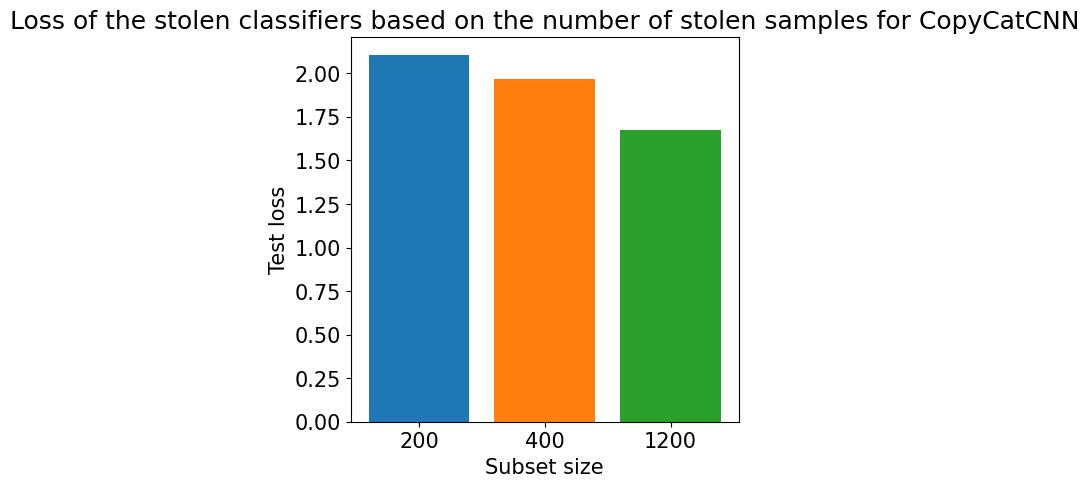

In [ ]:
import matplotlib.pyplot as plt
import matplotlib
# Converting the dict values to a Python list
score_values1 = list(scores1.values())

# Creating a matplotlib figure
fig = plt.figure(figsize=(5, 5))

# Iterating over our data subsets, plotting the test loss for each
for i in range(len(data_subsets_to_try)):
    plt.bar(
        x=str(data_subsets_to_try[i]),
        height=score_values1[i][0]
        )

# Setting a title for the figure and showing it
plt.title(label="Loss of the stolen classifiers based on the number of stolen samples for CopyCatCNN")
plt.xlabel(xlabel="Subset size")
plt.ylabel(ylabel="Test loss")
plt.show()

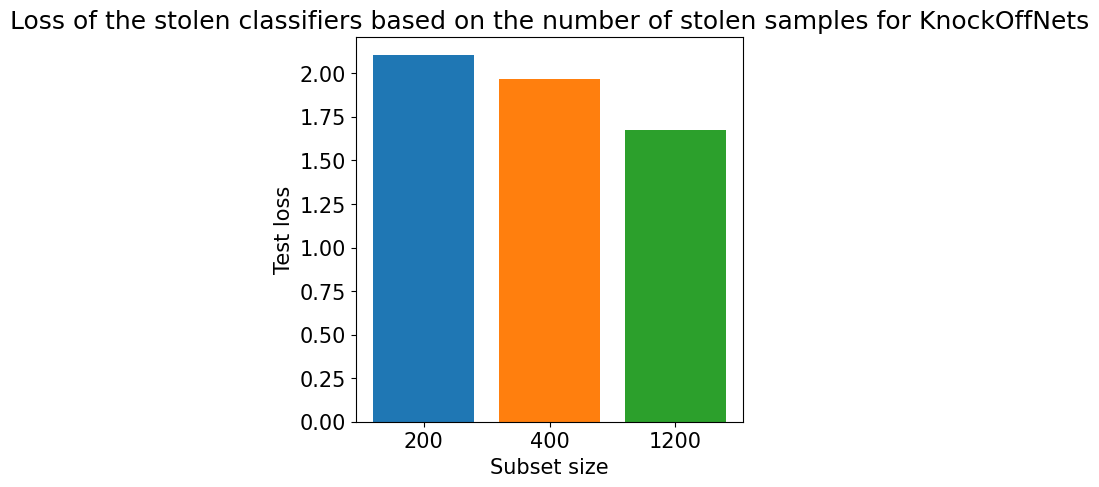

In [ ]:
import matplotlib.pyplot as plt
import matplotlib
# Converting the dict values to a Python list
score_values2 = list(scores1.values())

# Creating a matplotlib figure
fig = plt.figure(figsize=(5, 5))

# Iterating over our data subsets,
# plotting the test loss for each
for i in range(len(data_subsets_to_try)):
    plt.bar(
        x=str(data_subsets_to_try[i]),
        height=score_values2[i][0]
        )

# Setting a title for the figure and showing it
plt.title(label="Loss of the stolen classifiers based on the number of stolen samples for KnockOffNets")
plt.xlabel(xlabel="Subset size")
plt.ylabel(ylabel="Test loss")
plt.show()

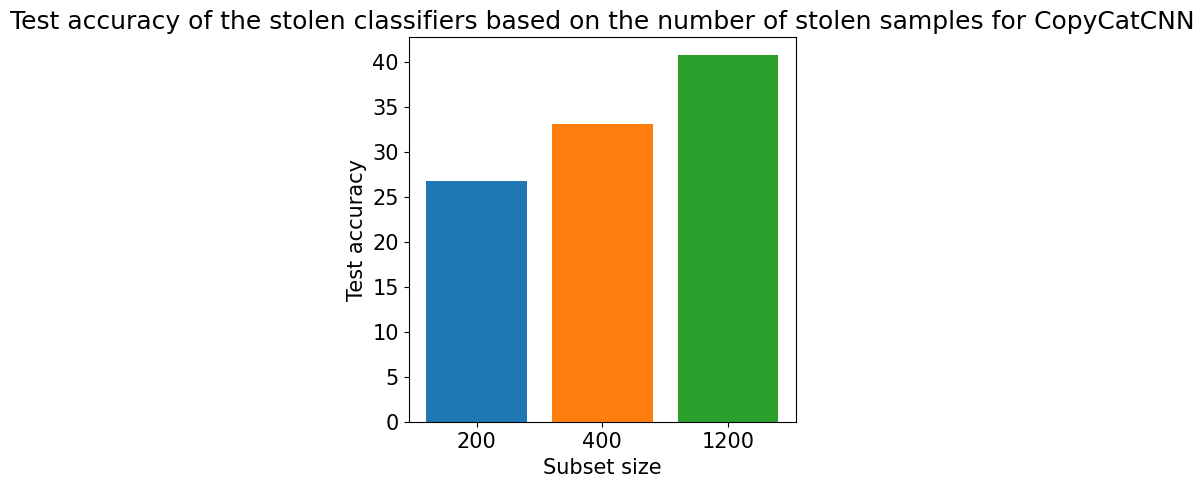

In [ ]:
# Creating a matplotlib figure
fig = plt.figure(figsize=(5, 5))

# Iterating over our data subsets,
# plotting the test accuracy for each
for i in range(len(data_subsets_to_try)):
    plt.bar(
        x=str(data_subsets_to_try[i]),
        height=score_values1[i][1] * 100
        )

# Setting a title for the figure and showing it
plt.title(label="Test accuracy of the stolen classifiers based on the number of stolen samples for CopyCatCNN")
plt.xlabel(xlabel="Subset size")
plt.ylabel(ylabel="Test accuracy")
plt.show()

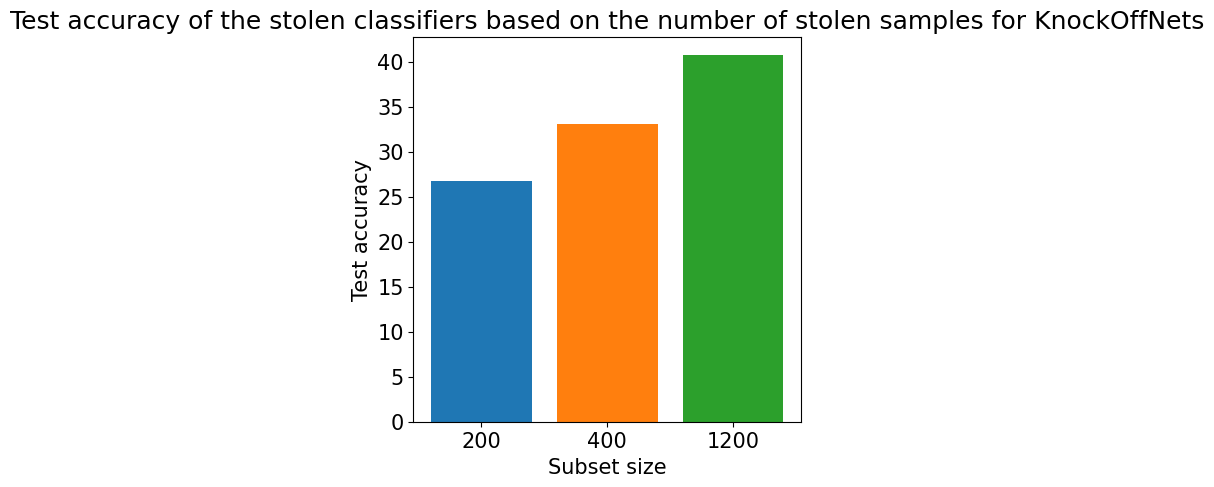

In [ ]:
# Creating a matplotlib figure
fig = plt.figure(figsize=(5, 5))

# Iterating over our data subsets,plotting the test accuracy for each
for i in range(len(data_subsets_to_try)):
    plt.bar(
        x=str(data_subsets_to_try[i]),
        height=score_values2[i][1] * 100
        )

# Setting a title for the figure and showing it
plt.title(label="Test accuracy of the stolen classifiers based on the number of stolen samples for KnockOffNets")
plt.xlabel(xlabel="Subset size")
plt.ylabel(ylabel="Test accuracy")
plt.show()

In [ ]:
partial_x_train = train_images_stolen
partial_y_train = train_labels_stolen
partial_x_train = partial_x_train.reshape(-1,32*32*3)

In [ ]:
#Remove this cell
from keras.models import Sequential
from keras.layers import Activation, Dense
fen_eval_model = Sequential()
fen_eval_model.add(Dense(1024, activation="relu", input_shape=(32*32*3,)))
fen_eval_model.add(Dense(10, activation="linear"))

fen_eval_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])


In [ ]:
#Remove this cell
fen_eval_model.fit(train_images.reshape(-1,32*32*3), train_labels, batch_size=32, epochs=10, verbose=1)

Train on 50000 samples
Epoch 1/10
50000/50000 [==============================] - 5s 106us/sample - loss: 11.1449 - accuracy: 0.1020
Epoch 2/10
50000/50000 [==============================] - 5s 93us/sample - loss: 11.2717 - accuracy: 0.1021
Epoch 3/10
50000/50000 [==============================] - 7s 131us/sample - loss: 11.2717 - accuracy: 0.1021
Epoch 4/10
50000/50000 [==============================] - 6s 111us/sample - loss: 11.2717 - accuracy: 0.1021
Epoch 5/10
50000/50000 [==============================] - 5s 102us/sample - loss: 11.2717 - accuracy: 0.1021
Epoch 6/10
50000/50000 [==============================] - 5s 107us/sample - loss: 11.2717 - accuracy: 0.1021
Epoch 7/10
50000/50000 [==============================] - 5s 95us/sample - loss: 11.2717 - accuracy: 0.1021
Epoch 8/10
50000/50000 [==============================] - 6s 110us/sample - loss: 11.2717 - accuracy: 0.1021
Epoch 9/10
50000/50000 [==============================] - 5s 93us/sample - loss: 11.2717 - accuracy: 0.1021

In [ ]:
def build_ganeval_model_flat():
    K.clear_session()
    model_url = "https://tfhub.dev/deepmind/ganeval-cifar10-convnet/1"
    ganeval_module = hub.Module(model_url)

    model = Sequential()
    model.add(Reshape((32,32,3),input_shape=(32*32*3,)))
    model.add(hub.KerasLayer(ganeval_module))
    model.add(Activation('relu'))

    model.compile(loss="categorical_crossentropy", optimizer="SGD", metrics=["accuracy"])

    return model

In [ ]:
ge_flat_clf = build_ganeval_model_flat()

# To display a summary of the model's architecture, including the layers and the number of parameters in each layer.
ge_flat_clf.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 32, 32, 3)         0         
                                                                 
 keras_layer (KerasLayer)    (None, 10)                7796426   
                                                                 
 activation (Activation)     (None, 10)                0         
                                                                 
Total params: 7,796,426
Trainable params: 0
Non-trainable params: 7,796,426
_________________________________________________________________


In [ ]:
ge_flat_clf.evaluate(partial_x_train, partial_y_train)

[0.26565913746667946, 0.99995655]

# Functionally Equivalent Extraction

A learning-based attack exploiting the victim to supervise the training of an extracted model. Extracting a functionally-equivalent model whose predictions are identical to those of the victim model on all possible inputs.

In [ ]:
from art.attacks.extraction import FunctionallyEquivalentExtraction

In [ ]:
model_url = "https://tfhub.dev/deepmind/ganeval-cifar10-convnet/1"
hub_layer = hub.KerasLayer(model_url, input_shape=(32, 32, 3), trainable=False)

model = tf.keras.Sequential([
    tf.keras.layers.InputLayer([3072]),
    tf.keras.layers.Reshape([32, 32, 3]),
    hub_layer,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.fit(train_images.reshape(-1,32*32*3), train_labels, epochs=15, batch_size=200, validation_split=0.1)

Train on 45000 samples, validate on 5000 samples
Epoch 1/15
45000/45000 [==============================] - 9s 208us/sample - loss: 0.0989 - accuracy: 0.9917 - val_loss: 0.0783 - val_accuracy: 0.9936
Epoch 2/15
45000/45000 [==============================] - 9s 207us/sample - loss: 0.0600 - accuracy: 0.9972 - val_loss: 0.0521 - val_accuracy: 0.9972
Epoch 3/15
45000/45000 [==============================] - 9s 209us/sample - loss: 0.0418 - accuracy: 0.9986 - val_loss: 0.0380 - val_accuracy: 0.9984
Epoch 4/15
45000/45000 [==============================] - 9s 209us/sample - loss: 0.0314 - accuracy: 0.9991 - val_loss: 0.0294 - val_accuracy: 0.9988
Epoch 5/15
45000/45000 [==============================] - 10s 213us/sample - loss: 0.0247 - accuracy: 0.9994 - val_loss: 0.0236 - val_accuracy: 0.9990
Epoch 6/15
45000/45000 [==============================] - 10s 219us/sample - loss: 0.0201 - accuracy: 0.9996 - val_loss: 0.0195 - val_accuracy: 0.9990
Epoch 7/15
45000/45000 [=========================

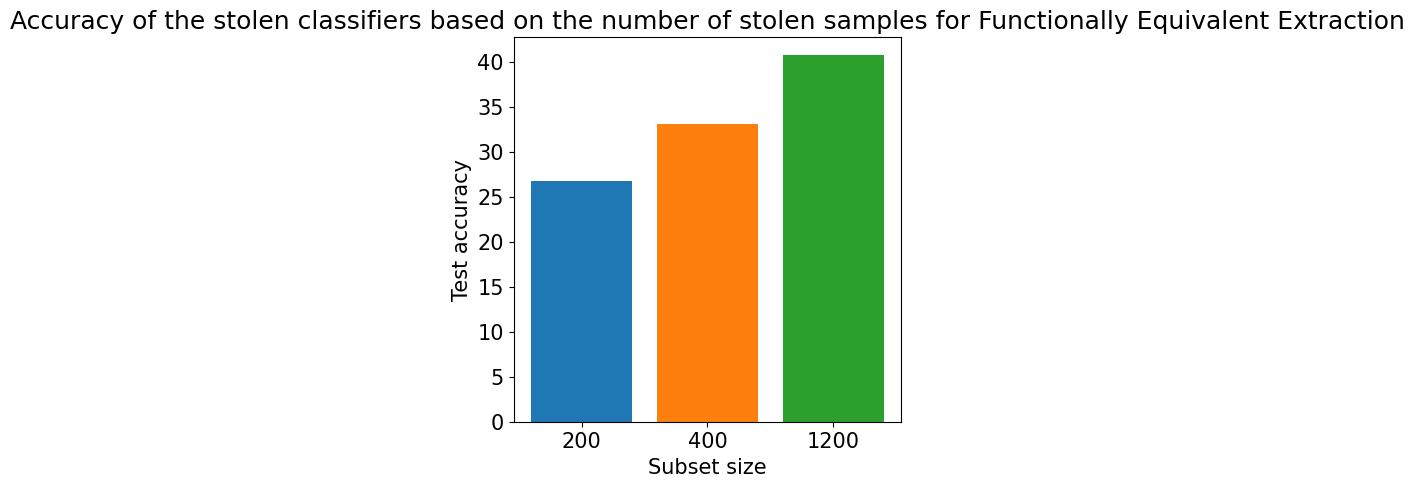

In [ ]:
# Creating a matplotlib figure
fig = plt.figure(figsize=(5, 5))

# Iterating over our data subsets,plotting the test accuracy for each
for i in range(len(data_subsets_to_try)):
    plt.bar(
        x=str(data_subsets_to_try[i]),
        height=score_values2[i][1] * 100
        )

# Setting a title for the figure and showing it
plt.title(label="Accuracy of the stolen classifiers based on the number of stolen samples for Functionally Equivalent Extraction")
plt.xlabel(xlabel="Subset size")
plt.ylabel(ylabel="Test accuracy")
plt.show()